<center>
    <h1> INF510 - Advanced Computational Methods  </h1>
    <h2> Homework #3 - Spectral Methods  </h2> 
</center>

* Martín Villanueva - `martin.villanueva@usm.cl` - **rol:** 201104012-0

_DI UTFSM. February 2016._

In [1]:
#%matplotlib notebook
%matplotlib inline 

import numpy as np
import numpy.fft as fft
from scipy.linalg import toeplitz
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed, IntSlider, FloatSlider

### Helper functions

In [2]:
def cheb(N):
    if N==0:
        D=0.
        x=1.
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x

def plot_helper(x, t, u, index):
    plt.plot(x, u[index], 'ro-')
    plt.title('Plot of $u(x,t)$ at t={0}'.format(t[index]))
    plt.xlabel('$x$')
    plt.ylabel('$u(x,t)$')
    plt.show()
    
def _plot_helper(x, t, u, index):
    plt.axes([.1,.1,.8,.7])
    plt.title('Plot of $u(x,t)$ at t={0}'.format(t[index]))
    plt.text(1.1, 1.1, '$u(0,t)=${0}'.format(u[index, len(x)/2]))
    plt.xlabel('$x$')
    plt.ylabel('$u(x,t)$')
    plt.plot(x, u[index], 'ro-')
    plt.show()

def plot_helper2(xx, yy, V, t, index):  
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, V[index], linewidth=0.0, cmap='jet')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('v')
    plt.title('Solution of $u(x,y,t)$ at t={0}'.format(t[index]))
    plt.show()
    
def lines_plot(xgrid, tgrid, U, xlim=None, tlim=None, ulim=None, title=None, numli=20.):
    udata = list()
    tdata = list()
    
    delta = int(U.shape[0]/float(numli))
    for i in range(U.shape[0]):
        if i%delta != 0: continue
        tdata.append(tgrid[i])
        udata.append( zip(xgrid, U[i]) )

    fig = plt.figure(figsize=(12,6))
    ax = fig.gca(projection='3d')
    lc = LineCollection(udata)
    lc.set_alpha(0.5)
    ax.add_collection3d(lc, zs=tdata, zdir='y')
    ax.set_xlabel('x')
    ax.set_xlim3d(xlim)
    ax.set_ylabel('t')
    ax.set_ylim3d(tlim)
    ax.set_zlabel('u')
    ax.set_zlim3d(ulim)
    ax.view_init(elev=45., azim=245)
    plt.title(title)
    plt.show()

## `Problem 1`

### `Program 27`


The problem consists in solving the KdV equation (_Korteweg–de Vries_), which takes the form:
$$ u_t = u u_x + u_{xxx}, $$
in the $[-\pi,\pi]$ domain. This equation corresponds to a mathematical model of waves on shallow water surfaces, known because it is an exactly solvable equation.


The initial conditions are solitary waves (solitons) of the form:
$$ u(x,t) = 3 a^2 \text{sech}^2\left(\frac{a(x-x_0)}{2}-a^3 t\right). $$


We are not interested in the boundary conditions since the solutions decay exponentially (the implicit assumption is that $u(\cdot,t)=0$ at the boundary).


Since the nonlinearity term causes trouble in an explicit time-stepping method (it would work but with very small time steps for stable solutions), some arrangements are done.  These arrangements are based on the _method of integrating factors_, and work by suppressing the influence of the term $u_{xxx}$ which is the one involving high frequencies. We start applying the Fourier transform in space to the KdV equation as follows:
\begin{align}
u_t + \left(\frac{1}{2} u^2 \right)_x + u_{xxx} &= 0 \ \ \ \ \ \ \ / \mathcal{F}() \\
\widehat{u_t} + \frac{i}{2} k \widehat{u^2} - i k^3 \widehat{u} &= 0 \ \ \ \ \ \ \ / \cdot e^{-ik^3 t} \\
e^{-ik^3 t} \widehat{u_t} + \frac{i}{2} k e^{-ik^3 t}  \widehat{u^2} - i e^{-ik^3 t} k^3 \widehat{u} &= 0 \ \ \ \ \ \ \ \text{if } \widehat{U} = e^{-ik^3 t} \widehat{u} \ \text{with } \widehat{U}_t = -ik^3 \widehat{U} + e^{-ik^3 t} \widehat{u}_t \\
\widehat{U}_t + \frac{i}{2} k e^{-ik^3 t}  \widehat{u^2} &= 0\\
\widehat{U}_t + \frac{i}{2} k e^{-i k^3 t} \mathcal{F}((\mathcal{F}^{-1}(e^{ik^3 t} \widehat{U}))^2) &= 0
\end{align}
The last equation is much more simple to solve and the influence of the linear term (the one with the high frequency) is gone. Now we perform finite-difference in time on the _Fourier space_.  The algorithm works as follows:
1. Map the initial condition to the fourier space with the corresponding factor: $\widehat{U}_0 = e^{-ik^3 t} \widehat{u}_0$.
2. Run a simple ODE solver over $\widehat{U}_t + \frac{i}{2}ke^{-ik^3t} \widehat{u^2} = 0$ as usual (RK4 is used here, for stability reasons).
3. The retrieve the solution in the original space, compute the inverse Fourier transform of $\widehat{U}_{\text{final}}$: $\ \ \ \ u = \mathcal{F}^{-1}(e^{\epsilon (ik)^2 t} \widehat{U})$.

In the two cells below you can see the implementation of the algorithm:

In [13]:
# number of grid points
N = 256

# time step
dt = .4/N**2

# x-grid
xgrid = (2*np.pi/N) * np.linspace(-N/2, N/2-1, N)

# some problem constants
A = 25.; B = 16.

# initial conditions
u0 = (3*A**2) * np.cosh(.5*A*(xgrid+2))**(-2) + (3*B**2) * np.cosh(.5*B*(xgrid+1))**(-2)
v = np.fft.fft(u0)

# wave numbers
k = np.concatenate((np.arange(0,N/2), np.array([0]), np.arange(-N/2+1,0,1)))

ik3 = 1j*k**3
E = np.exp(dt*ik3/2); E2 = E**2
g = -.5j*k*dt

# ODE solver parameters
tmax = 0.006
n_iter = int(round(tmax/dt))
time_grid = np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

In [14]:
for i in range(1, n_iter+1):
    # RK4 method
    k1 = g * np.fft.fft( np.real( np.fft.ifft( v ) )**2 )
    k2 = g * np.fft.fft( np.real( np.fft.ifft( E*(v + k1/2) ) )**2 )
    k3 = g * np.fft.fft( np.real( np.fft.ifft( E*v + k2/2 ) )**2 )
    k4 = g * np.fft.fft( np.real( np.fft.ifft( E2*v + E*k3 ) )**2 )
    v = E2*v + (E2*k1 + 2*E*(k2+k3) + k4)/6
    # we just store the solution at the original domain
    U[i] = np.real( np.fft.ifft(v) )

And in the cell below we show the resulting numerical solution to the KdV equation. As you can see, the two solitons at the initial time get closer as times goes on, then they interact with each other overlapping, and finally each solition continues on its path, which is the expected behaviour.

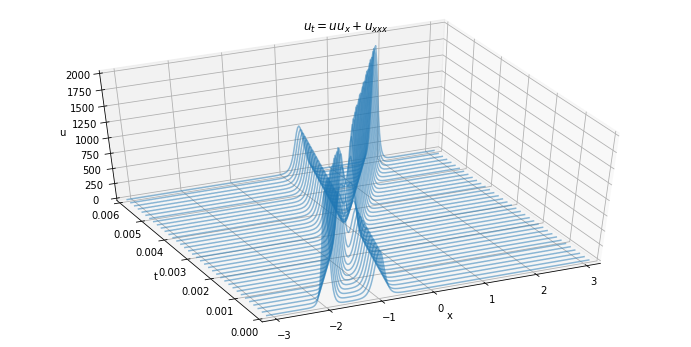

In [17]:
lines_plot(xgrid, time_grid, U, xlim=(-np.pi, np.pi), tlim=(0,tmax), ulim=(0,2000),
           numli=35, title='$u_t = u u_x + u_{xxx}$')

### `Program 34`

In [18]:
# number of grid points
N = 25

# differentiation matrix and initial data
D,x = cheb(N); D2 = np.dot(D,D)
D2[[0, -1]] = 0.

# parameter of the PDE
eps = 0.01

# time step
dt = min(0.01, 50/(eps*N**4)) 

# initial conditions
u0 = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)

# ode solver parameters
tmax = 100
n_iter = int(round(tmax/dt))
t= np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

# Euler method
for i in range(1, n_iter+1):
    U[i] = U[i-1] + dt * (eps*np.dot(D2, U[i-1]) + U[i-1] - U[i-1]**3)

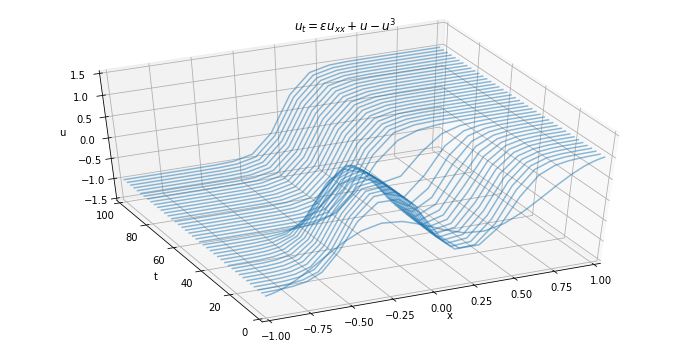

In [21]:
lines_plot(x, t, U, xlim=(-1.,1.), tlim=(0.,100.), ulim=(-1.5,1.5),
           numli=40, title='$u_t = \epsilon u_{xx} + u - u^3$')

### `Program 35`

In [24]:
# number of grid points
N = 20

# differentiation matrix and initial data
D,x = cheb(N); D2 = np.dot(D,D)

# parameter of the PDE
eps = 0.01

# time step
dt = min(0.01, 50/(eps*N**4)) 

# initial conditions
u0 = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)

# ode solver parameters
tmax = 100
n_iter = int(round(tmax/dt))
t = np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

# Euler method
for i in range(1, n_iter+1):
    U[i] = U[i-1] + dt * (eps*np.dot(D2, U[i-1]) + U[i-1] - U[i-1]**3)
    U[i, 0] = 1 + np.sin(t[i]/5)**2; U[i, -1] = -1

<IPython.core.display.Javascript object>


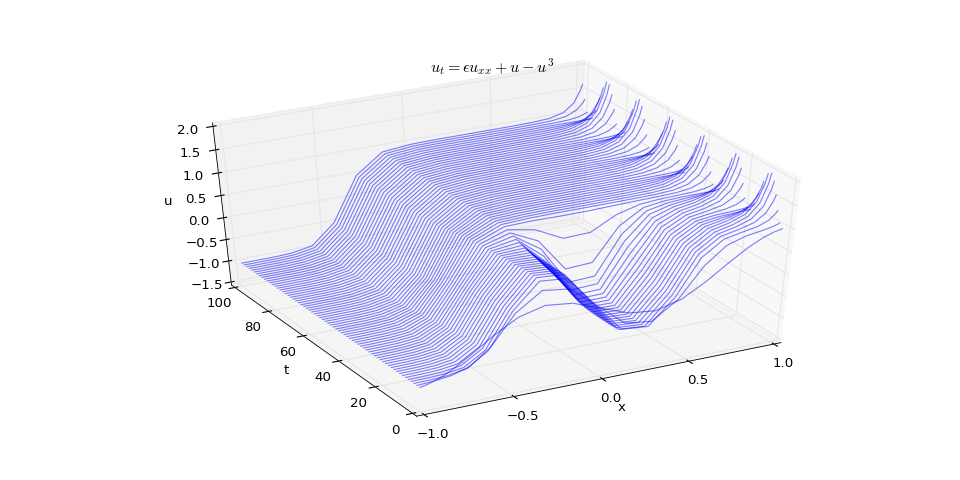

In [25]:
lines_plot(x, t, U, tjump=150, xlim=(-1.,1.), tlim=(0.,100.), ulim=(-1.5,2.0), title='$u_t = \epsilon u_{xx} + u - u^3$')

### `Program 37`

In [5]:
# x variable in [A,-A], Fourier
A = 3.; Nx = 100; dx = 2.*A/Nx; x = np.arange(-A+dx, A+dx, dx)
row = np.concatenate(([-1/(3*(dx/A)**2)-1/6], (.5*(-1)**np.arange(2,Nx+1)) / np.sin((np.pi*dx/A) * np.arange(1,Nx)/2)**2))
D2x = (np.pi/A)**2 * toeplitz(row)

# y variable in [-1, 1], Chebyshev
Ny = 30; Dy,y = cheb(Ny); D2y = np.dot(Dy, Dy)
BC = np.linalg.solve(-Dy[[0,0,-1,-1],[0,-1,0,-1]].reshape((2,2)), Dy[[0,-1],1:Ny])


# ode solver parameters
dt = 5./(Nx+Ny**2)
tmax = 5
n_iter = int(round(tmax/dt))
t = np.linspace(0., tmax, n_iter+1)

# grid an initial data
xx,yy = np.meshgrid(x, y)
vv = np.exp(-8.*((xx+1.5)**2 + yy**2))
vvold = np.exp(-8.*((xx+dt+1.5)**2 + yy**2))

# solution array
V = np.empty((n_iter+1, vv.shape[0], vv.shape[1]))
V[0] = vv

# Leap-Frog method
for i in range(1, n_iter+1):
    vvnew = 2*vv - vvold + (dt**2)*(np.dot(vv,D2x) + np.dot(D2y,vv))
    vvold = vv; vv = vvnew
    vv[[0,-1]] = np.dot(BC, vv[1:Ny])
    V[i] = vv

In [7]:
interact(plot_helper2, xx=fixed(xx), yy=fixed(yy),
         V=fixed(V), t=fixed(t), index=(0,len(t)));

interactive(children=(IntSlider(value=500, description=u'index', max=1001), Output()), _dom_classes=('widget-interact',))

***
***
## `Problem 2`

__Note:__ This corresponds to exercise 10.4 from _Spectral Methods in Matlab, Trefethen._

In [11]:
# number of grid points
N = 30

# differentiation matrix and initial data
D,x = cheb(N); D2 = np.dot(D,D)

# initial condition
u0 = np.zeros(x.shape[0])

# ode solver parameters
dt = 0.00001
tmax = 3.6
n_iter = int(round(tmax/dt))
t = np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

def ut_approx(u):
    """
    It takes the values of u(x,t) at a given time t,
    and computes the temporal derivatives
    """
    return np.dot(D2, u) + np.exp(u)

# ODO solver to use
method = 'rk4'

if method=='euler':
    # Euler method
    for i in range(1, n_iter+1):
        U[i] = U[i-1] + dt * ut_approx(U[i-1])
        # enforcing boundary conditions
        U[i,0] = U[i,-1] = 0

elif method=='rk4':
    # RK4 method
    for i in range(1, n_iter+1):
        k1 = ut_approx( U[i-1] )
        k2 = ut_approx( U[i-1] + (dt/2.)*k1 )
        k3 = ut_approx( U[i-1] + (dt/2.)*k2 )
        k4 = ut_approx( U[i-1] + dt*k3)
        U[i] = U[i-1] + (dt/6.)*(k1 + 2*k2 + 2*k3 + k4)
        # enforcing boundary conditions
        U[i,0] = U[i,-1] = 0

/Users/martin/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
/Users/martin/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in add


In [12]:
interact(_plot_helper, x=fixed(x), t=fixed(t), u=fixed(U), index=(0, len(t)-1))

interactive(children=(IntSlider(value=180000, description=u'index', max=360000), Output()), _dom_classes=('widget-interact',))

<function __main__._plot_helper>

***
***
## `Problem 3`

__Note:__ This corresponds to exercise 10.7 from _Spectral Methods in Matlab, Trefethen._

In this problem we are asked to solve numerically the **Kuramoto-Sivashinsky** equation in one spatial dimension:

$$
u_t = - (u^2)_x - u_{xx} - u_{xxxx},
$$

which can also be written in this form by differentiating $(u^2)_x$:

$$
u_t =  - 2 u u_x - u_{xx} - u_{xxxx},
$$

with periodic boundary conditions on the domain $[-20,20]$ and initial conditions $u(x,0)=\exp(-x^2)$.

As usual, we will compute the spatial derivatives with spectral methods, and finite differences is used in time with a time-stepping method (Euler and RK4 are implemented in this case).

Since in this problem we have a bounded and periodic grid, the most straightforward way to solve it is by means of Fourier methods. Particularly, we decided to use the implementation with the DFT, since require less FLOPS [$O(N \log N)$] than the differentiation matrix approach [$O(N^2)$]. The method is as follows:

* Given $u$, compute $\widehat{u}$.
* Define $\widehat{w}_k = (ik)^\nu \widehat{u}_k$, but $\widehat{w}_{N/2}=0$ if $\nu$ is odd.
* Compute $w$ from $\widehat{w}$.

In the two cells below you can see the numerical solution: The initial configuration and the time-stepping, respectively.

In [3]:
# number of grid points
N = 32

# spatial grid and initial condition
xgrid = np.linspace(-20,20,N)

# wave numbers
k_even = np.fft.fftfreq(N, 1./N)
k_odd = np.fft.fftfreq(N, 1./N); k_odd[N/2] = 0
ik = 1j*k_odd
ik2 = (1j*k_even)**2
ik4 = (1j*k_even)**4

# initial condition
u0 = np.exp(-xgrid**2)

# ODE solver parameters
dt = 1e-5
tmax = 50
n_iter = int(round(tmax/dt))
time_grid = np.linspace(0., 50., n_iter/1000)

# spatial approximation function
# (computes the right side of the PDE above)
# i.e., an approximation of u_t 
def ut_approx(u):
    u_hat = fft.fft(u)
    return -2*u*np.real(fft.ifft(ik*u_hat)) \
           -np.real(fft.ifft(ik2*u_hat)) \
           -np.real(fft.ifft(ik4*u_hat))

In [4]:
# ODE solver to use
method = 'euler'

# note: since the time step is too short in this case,
# we do not store the solution at every time, but every
# 1000 iterations
usol = np.zeros((n_iter/1000, len(u0)))
usol[0,:] = u0

if method=='euler':
    # Euler method
    u = np.copy(u0)
    for i in range(1, n_iter):
        u += dt * ut_approx(u)
        if i%1000==0:
            usol[i/1000,:] = u
            
elif method=='RK4':
    # RK4 method
    u = np.copy(u0)
    for i in range(n_iter):
        if i%1000==0:
            usol.append(u)
        k1 = ut_approx(u)
        k2 = ut_approx(u + (dt/2.)*k1)
        k3 = ut_approx(u + (dt/2.)*k2)
        k4 = ut_approx(u + dt*k3)
        u += (dt/6.)*(k1 + 2*k2 + 2*k3 + k4)


The Kuramoto-Sivashinsky equation was very difficult to solve numerically, requiring a tiny time-step ($10^{-5}$) for the the Euler method and RK4. 

Below we show the equation's solution in two ways: in an interactive plot and a lines plot. We only show the solution obtained with Euler's method, because of the long time required for RK4 to finish.

In [8]:
interact(plot_helper, x=fixed(xgrid), t=fixed(time_grid), 
         u=fixed(usol), index=IntSlider(min=0,max=(n_iter/1000)-1,step=10,value=0));

interactive(children=(IntSlider(value=0, description=u'index', max=4999, step=10), Output()), _dom_classes=('widget-interact',))

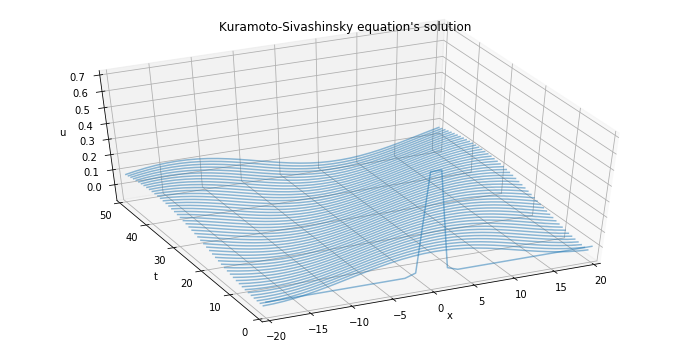

In [9]:
lines_plot(xgrid, time_grid, usol, 
           xlim=(-20, 20), tlim=(0,tmax), 
           ulim=(usol.min()-0.05,usol.max()+0.05),
           numli=50., title="Kuramoto-Sivashinsky equation's solution")

#### References for `Problem 3`

* Spectral methods in Matlab, Lloyd N. Trefethen, Chapter 3 - Periodic Grids: The DFT and FFT
* https://people.maths.ox.ac.uk/trefethen/pdectb/kuramoto2.pdf